In [1]:
import sys
sys.path.append("../..")
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib
import os
from surgeNN import io
import scipy
import gcsfs
fs = gcsfs.GCSFileSystem() #list stores, stripp zarr from filename, load 

In [2]:
def get_true_sequence_lens(a): #get sequence length of True's in a boolean array
    # Convert to array
    a = np.asarray(a)

    # Attach sentients on either sides w.r.t True
    b = np.r_[False,a,False]

    # Get indices of group shifts
    s = np.flatnonzero(b[:-1]!=b[1:])

    # Get group lengths and hence the max index group
    m = np.array(s[1::2]-s[::2])

    return m

def get_number_of_runs_with_max_stagnant_loss(ds,patience):
    not_lower = ((ds.val_loss != ds.val_loss.rolling(e=patience+1,min_periods=1).min()) & np.isfinite(ds.val_loss))
    n_max_stagnant = np.zeros(len(ds.tg))
    
    for t,tg in enumerate(ds.tg):
        for i in ds.i:
            for it in ds.it:
                true_seq_lens = get_true_sequence_lens(not_lower.sel(tg=tg,it=it,i=i)) #get lengths of series of stagnant (=not decreasing) val_loss
                n_max_stagnant[t] += (np.sum(true_seq_lens == patience-1)>0) #if current it & i combination had a series of stagnant losses with length patience minus 1
    return n_max_stagnant

def compute_pearsonr(a,b):
    isfinite = np.isfinite(a*b)
    stats = scipy.stats.pearsonr(a[isfinite],b[isfinite])
    return stats.statistic,stats.pvalue

In [3]:
#configure the script
tgs        = ['stavanger-svg-nor-nhs.csv','wick-wic-gbr-bodc.csv','esbjerg-esb-dnk-dmi.csv','immingham-imm-gbr-bodc.csv','den_helder-denhdr-nld-rws.csv', 'fishguard-fis-gbr-bodc.csv',  'brest-822a-fra-uhslc.csv', 'vigo-vigo-esp-ieo.csv',  'alicante_i_outer_harbour-alio-esp-da_mm.csv']
tgnames = ['Stavanger (NOR)','Wick (UK)', 'Esbjerg (DK)','Immingham (UK)','Den Helder (NL)','Fishguard (UK)','Brest (FR)','Vigo (PT)', 'Alicante (SP)']

qnts = np.array([.95,.98,.99,.995]) #quantiles, don't touch

max_timesteps_between_extremes = 3

In [4]:
lstms = io.Output('gs://leap-persistent/timh37/surgeNN_output/nns/performance_modified/lstm')
#lstms = io.Output('/home/jovyan/test_surge_models/results/nns_v2/performance/lstm')
lstms.open_performance_data(tgs)
lstms.data = lstms.data.sel(max_timesteps_between_extremes=max_timesteps_between_extremes).load()

#compute metrics for observations (it,i doesn't matter as long as all models have been run with the same n_t)
observed_thresholds = lstms.observed_thresholds()
observed_stds = lstms.observed_stds()

lstms=lstms.data

convlstms = io.Output('gs://leap-persistent/timh37/surgeNN_output/nns/performance_modified/convlstm')
#convlstms = io.Output('/home/jovyan/test_surge_models/results/nns_v2/performance/convlstm')
convlstms.open_performance_data(tgs)
convlstms = convlstms.data.sel(max_timesteps_between_extremes=max_timesteps_between_extremes).load()

Find the fraction of runs for each tide gauge that had 1 or more consecutive series of patience-1 epochs without further decreases in the val_loss

In [5]:
get_number_of_runs_with_max_stagnant_loss(lstms,10)/(len(lstms.it)*len(lstms.i))

array([0.05833333, 0.18333333, 0.125     , 0.13333333, 0.11666667,
       0.16666667, 0.125     , 0.04166667, 0.04166667])

In [6]:
get_number_of_runs_with_max_stagnant_loss(convlstms,10)/(len(convlstms.it)*len(convlstms.i))

array([0.3       , 0.26666667, 0.1       , 0.13333333, 0.36666667,
       0.3       , 0.2       , 0.06666667, 0.16666667])

Find the fraction of runs for each tide gauge for which the maximum number of epochs were used for training:

In [7]:
(np.isfinite(lstms.val_loss).sum(dim='e')==len(lstms.e)).sum(dim=('i','it')).values/(len(lstms.i)*len(lstms.it)) #per tg

array([0.        , 0.03333333, 0.04166667, 0.25833333, 0.175     ,
       0.00833333, 0.05      , 0.        , 0.        ])

In [8]:
(np.isfinite(lstms.val_loss).sum(dim='e')==len(lstms.e)).sum(dim=('i','it','tg')).values/(len(lstms.i)*len(lstms.it)*len(lstms.tg)) #total

0.06296296296296296

In [9]:
(np.isfinite(convlstms.val_loss).sum(dim='e')==len(convlstms.e)).sum(dim=('i','it')).values/(len(convlstms.i)*len(convlstms.it)) #per tg

array([0.03333333, 0.03333333, 0.        , 0.13333333, 0.06666667,
       0.        , 0.23333333, 0.        , 0.        ])

In [10]:
(np.isfinite(convlstms.val_loss).sum(dim='e')==len(lstms.e)).sum(dim=('i','it','tg')).values/(len(convlstms.i)*len(convlstms.it)*len(convlstms.tg)) #total

0.05555555555555555

Compute average decrement in validation loss over the last n decrements:

In [17]:
n_decr = 5
avg_decr = np.nan * np.zeros((len(lstms.tg),len(lstms.i),len(lstms.it)))
avg_dur = np.nan * np.zeros((len(lstms.tg),len(lstms.i),len(lstms.it)))
for t,tg in enumerate(lstms.tg):
    for i in lstms.i:
        for it in lstms.it:
            val_loss = lstms.val_loss.sel(tg=tg,i=i,it=it)
            a = np.nan*val_loss.values
            
            for k in np.arange(100):
                if np.isfinite(val_loss[k])==False:
                    continue
                else:
                    if val_loss[k] == np.min(val_loss[0:k+1]):
                        a[k] = val_loss[k]

            avg_decr[t,i,it] = 100*np.mean((np.diff(a[np.isfinite(a)])/a[np.isfinite(a)][0::-1])[-n_decr::]) #average percentual decrease of the validation loss over the last n decrements
            if len(get_true_sequence_lens(np.isnan(a))[get_true_sequence_lens(np.isnan(a))<10][-n_decr::]) >0:
                avg_dur[t,i,it] = np.mean(get_true_sequence_lens(np.isnan(a))[get_true_sequence_lens(np.isnan(a))<10][-n_decr::])
            else:
                avg_dur[t,i,it] = np.nan    
lstms['avg_val_loss_decrease'] = (('tg','i','it'),avg_decr)
lstms['avg_val_loss_decrease_n_epochs'] = (('tg','i','it'),avg_dur)

In [19]:
n_decr =5
avg_decr = np.nan * np.zeros((len(convlstms.tg),len(convlstms.i),len(convlstms.it)))
avg_dur = np.nan * np.zeros((len(convlstms.tg),len(convlstms.i),len(convlstms.it)))
for t,tg in enumerate(convlstms.tg):
    for i in convlstms.i:
        for it in convlstms.it:
            val_loss = convlstms.val_loss.sel(tg=tg,i=i,it=it)
            a = np.nan*val_loss.values
            
            for k in np.arange(100):
                if np.isfinite(val_loss[k])==False:
                    continue
                else:
                    if val_loss[k] == np.min(val_loss[0:k+1]):
                        a[k] = val_loss[k]

            avg_decr[t,i,it] = 100*np.mean((np.diff(a[np.isfinite(a)])/a[np.isfinite(a)][0::-1])[-n_decr::]) #average percentual decrease of the validation loss over the last n decrements
            if len(get_true_sequence_lens(np.isnan(a))[get_true_sequence_lens(np.isnan(a))<10][-n_decr::]) >0:
                avg_dur[t,i,it] = np.mean(get_true_sequence_lens(np.isnan(a))[get_true_sequence_lens(np.isnan(a))<10][-n_decr::])
            else:
                avg_dur[t,i,it] = np.nan 
convlstms['avg_val_loss_decrease'] = (('tg','i','it'),avg_decr)
convlstms['avg_val_loss_decrease_n_epochs'] = (('tg','i','it'),avg_dur)

In [18]:
lstms['avg_val_loss_decrease'].where(np.isfinite(lstms.val_loss).sum(dim='e')==len(lstms.e)).mean(dim=('i','it'))

<xarray.DataArray 'avg_val_loss_decrease' (tg: 9)>
array([        nan, -0.2256627 , -0.17958042, -0.18287794, -0.18108927,
       -0.13748966, -0.17315868,         nan,         nan])
Coordinates:
    max_timesteps_between_extremes  int64 3
  * tg                              (tg) <U43 'stavanger-svg-nor-nhs.csv' ......
    lat                             (tg) float64 58.97 58.44 ... 42.24 38.34
    lon                             (tg) float64 5.73 -3.086 ... -8.73 -0.4779

In [57]:
lstms['avg_val_loss_decrease_n_epochs'].where(np.isfinite(lstms.val_loss).sum(dim='e')==len(lstms.e)).mean(dim=('i','it'))

<xarray.DataArray 'avg_val_loss_decrease_n_epochs' (tg: 9)>
array([       nan, 5.1       , 4.6       , 3.63225806, 4.01904762,
       2.6       , 4.53333333,        nan,        nan])
Coordinates:
    max_timesteps_between_extremes  int64 3
  * tg                              (tg) <U43 'stavanger-svg-nor-nhs.csv' ......
    lat                             (tg) float64 58.97 58.44 ... 42.24 38.34
    lon                             (tg) float64 5.73 -3.086 ... -8.73 -0.4779

In [20]:
convlstms['avg_val_loss_decrease'].where(np.isfinite(convlstms.val_loss).sum(dim='e')==len(convlstms.e)).mean(dim=('i','it'))

<xarray.DataArray 'avg_val_loss_decrease' (tg: 9)>
array([-0.31189429, -0.35994373,         nan, -0.19241409, -0.27359487,
               nan, -0.38898618,         nan,         nan])
Coordinates:
    max_timesteps_between_extremes  int64 3
  * tg                              (tg) <U43 'stavanger-svg-nor-nhs.csv' ......
    lat                             (tg) float64 58.97 58.44 ... 42.24 38.34
    lon                             (tg) float64 5.73 -3.086 ... -8.73 -0.4779

In [21]:
convlstms['avg_val_loss_decrease_n_epochs'].where(np.isfinite(convlstms.val_loss).sum(dim='e')==len(convlstms.e)).mean(dim=('i','it'))

<xarray.DataArray 'avg_val_loss_decrease_n_epochs' (tg: 9)>
array([4.2       , 6.        ,        nan, 3.25      , 4.2       ,
              nan, 4.68571429,        nan,        nan])
Coordinates:
    max_timesteps_between_extremes  int64 3
  * tg                              (tg) <U43 'stavanger-svg-nor-nhs.csv' ......
    lat                             (tg) float64 58.97 58.44 ... 42.24 38.34
    lon                             (tg) float64 5.73 -3.086 ... -8.73 -0.4779

Plot validation v.s. test performance as a function of the dropout rate:

Text(0.5, 0.98, 'convlstms RMSE')

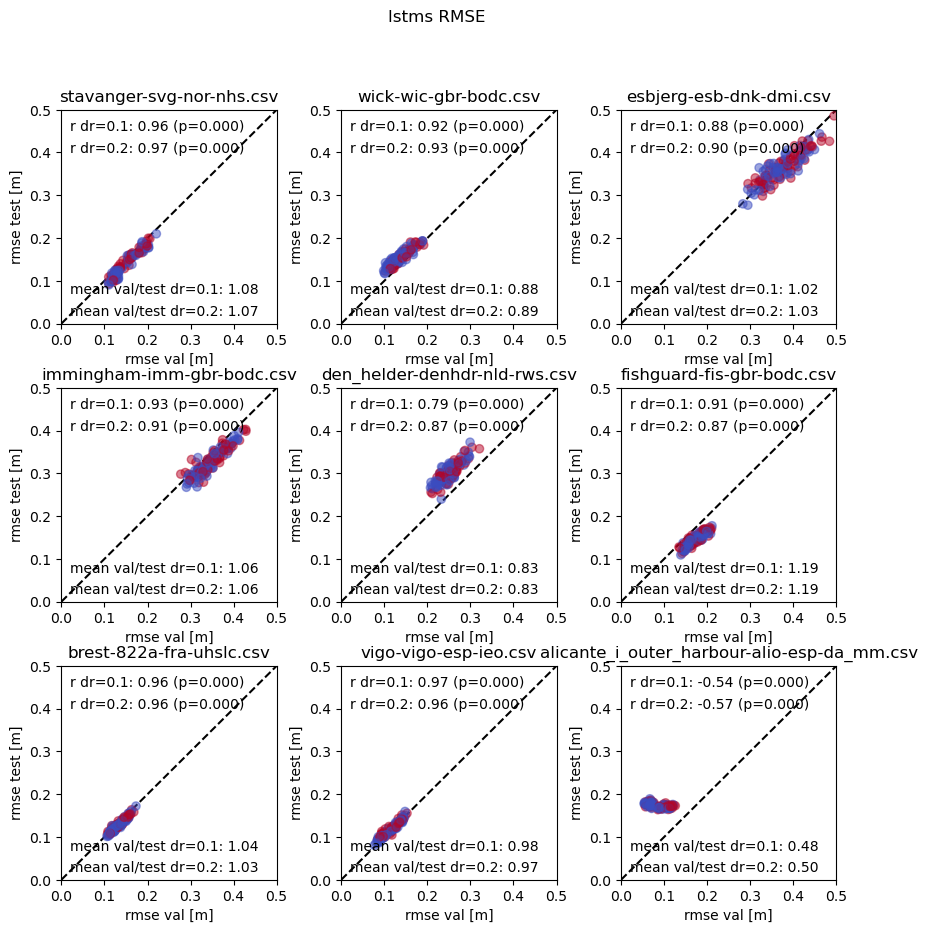

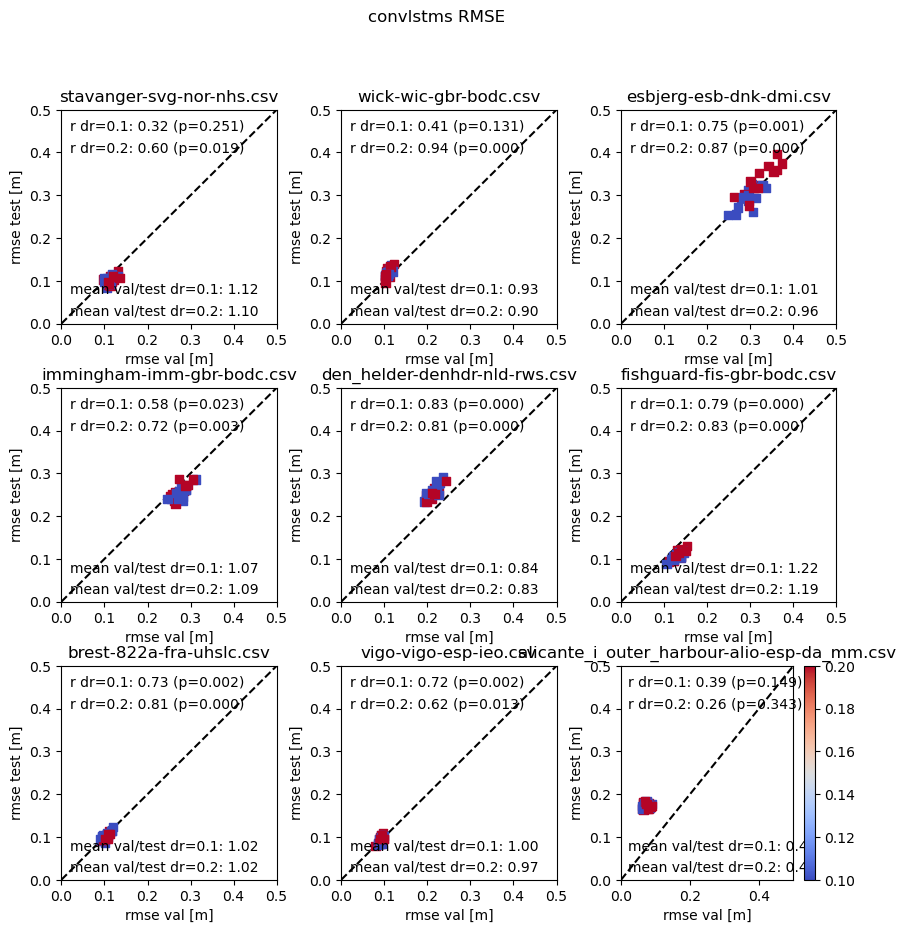

In [10]:
fig=plt.figure(figsize=(10,10)) 
gs = fig.add_gridspec(3,3) #1 row, 3 columns
gs.update(wspace=.3)
gs.update(hspace=.3)
for tg in range(9):
        ax = plt.subplot(gs[np.unravel_index(tg,(3,3))]) 
        
        ax.scatter(lstms.rmse_extremes.sel(quantile=.99).isel(tg=tg).sel(split='val').stack(i_it=['i','it']),
                   lstms.rmse_extremes.sel(quantile=.99).isel(tg=tg).sel(split='test').stack(i_it=['i','it']),c=lstms.hyperparameters.sel(p='dropout').isel(tg=2).sel(split='test').stack(i_it=['i','it']),cmap='coolwarm',alpha=.5)
        
        #add pearsons correlation val vs test
        r_01,p_01 = compute_pearsonr(lstms.rmse_extremes.sel(quantile=.99).where(lstms.hyperparameters.sel(p='dropout')==.1).isel(tg=tg).sel(split='val').values.flatten(),
                                     lstms.rmse_extremes.sel(quantile=.99).where(lstms.hyperparameters.sel(p='dropout')==.1).isel(tg=tg).sel(split='test').values.flatten())
        
        r_02,p_02 = compute_pearsonr(lstms.rmse_extremes.sel(quantile=.99).where(lstms.hyperparameters.sel(p='dropout')==.2).isel(tg=tg).sel(split='val').values.flatten(),
                                     lstms.rmse_extremes.sel(quantile=.99).where(lstms.hyperparameters.sel(p='dropout')==.2).isel(tg=tg).sel(split='test').values.flatten())
        
        ax.text(.02,.45,'r dr=0.1: '+'{0:.2f}'.format(r_01)+' (p='+'{0:.3f}'.format(p_01)+')')
        ax.text(.02,.4,'r dr=0.2: '+'{0:.2f}'.format(r_02)+' (p='+'{0:.3f}'.format(p_02)+')')
        
        #plot ratio of mean rmse ratio between splits:
        ax.text(.02,.07,'mean val/test dr=0.1: '+'{0:.2f}'.format(lstms.rmse_extremes.sel(quantile=.99).where(lstms.hyperparameters.sel(p='dropout')==.1).isel(tg=tg).sel(split='val').mean()/lstms.rmse_extremes.sel(quantile=.99).where(lstms.hyperparameters.sel(p='dropout')==.1).isel(tg=tg).sel(split='test').mean()))
        ax.text(.02,.02,'mean val/test dr=0.2: '+'{0:.2f}'.format(lstms.rmse_extremes.sel(quantile=.99).where(lstms.hyperparameters.sel(p='dropout')==.2).isel(tg=tg).sel(split='val').mean()/lstms.rmse_extremes.sel(quantile=.99).where(lstms.hyperparameters.sel(p='dropout')==.2).isel(tg=tg).sel(split='test').mean()))
        
        ax.set_title(lstms.tg.values[tg])
        ax.plot([0,.5],[0,.5],linestyle='dashed',color='black',zorder=0)
        ax.set_xlim(0,.5)
        ax.set_xlabel('rmse val [m]')
        ax.set_ylim(0,.5)
        ax.set_ylabel('rmse test [m]')
        
plt.suptitle('lstms RMSE')
fig=plt.figure(figsize=(10,10)) 
gs = fig.add_gridspec(3,3) #1 row, 3 columns
gs.update(wspace=.3)
gs.update(hspace=.3)
for tg in range(9):
        ax = plt.subplot(gs[np.unravel_index(tg,(3,3))]) 
        
        s=ax.scatter(convlstms.rmse_extremes.sel(quantile=.99).isel(tg=tg).sel(split='val').stack(i_it=['i','it']),
                   convlstms.rmse_extremes.sel(quantile=.99).isel(tg=tg).sel(split='test').stack(i_it=['i','it']),c=convlstms.hyperparameters.sel(p='dropout').isel(tg=2).sel(split='test').stack(i_it=['i','it']),cmap='coolwarm',marker='s',alpha=.5)
        
        r_01,p_01 = compute_pearsonr(convlstms.rmse_extremes.sel(quantile=.99).where(convlstms.hyperparameters.sel(p='dropout')==.1).isel(tg=tg).sel(split='val').values.flatten(),
                                     convlstms.rmse_extremes.sel(quantile=.99).where(convlstms.hyperparameters.sel(p='dropout')==.1).isel(tg=tg).sel(split='test').values.flatten())
        
        r_02,p_02 = compute_pearsonr(convlstms.rmse_extremes.sel(quantile=.99).where(convlstms.hyperparameters.sel(p='dropout')==.2).isel(tg=tg).sel(split='val').values.flatten(),
                                     convlstms.rmse_extremes.sel(quantile=.99).where(convlstms.hyperparameters.sel(p='dropout')==.2).isel(tg=tg).sel(split='test').values.flatten())
        
        
        ax.text(.02,.45,'r dr=0.1: '+'{0:.2f}'.format(r_01)+' (p='+'{0:.3f}'.format(p_01)+')')
        ax.text(.02,.4,'r dr=0.2: '+'{0:.2f}'.format(r_02)+' (p='+'{0:.3f}'.format(p_02)+')')
        
        ax.text(.02,.07,'mean val/test dr=0.1: '+'{0:.2f}'.format(convlstms.rmse_extremes.sel(quantile=.99).where(convlstms.hyperparameters.sel(p='dropout')==.1).isel(tg=tg).sel(split='val').mean()/convlstms.rmse_extremes.sel(quantile=.99).where(convlstms.hyperparameters.sel(p='dropout')==.1).isel(tg=tg).sel(split='test').mean()))
        ax.text(.02,.02,'mean val/test dr=0.2: '+'{0:.2f}'.format(convlstms.rmse_extremes.sel(quantile=.99).where(convlstms.hyperparameters.sel(p='dropout')==.2).isel(tg=tg).sel(split='val').mean()/convlstms.rmse_extremes.sel(quantile=.99).where(convlstms.hyperparameters.sel(p='dropout')==.2).isel(tg=tg).sel(split='test').mean()))
        

        ax.set_title(convlstms.tg.values[tg])
        ax.plot([0,.5],[0,.5],linestyle='dashed',color='black',zorder=0)
        ax.set_xlim(0,.5)
        ax.set_xlabel('rmse val [m]')
        ax.set_ylim(0,.5)
        ax.set_ylabel('rmse test [m]')
        
fig.colorbar(s, ax=ax)
plt.suptitle('convlstms RMSE')   

Text(0.5, 0.98, 'convlstms F1')

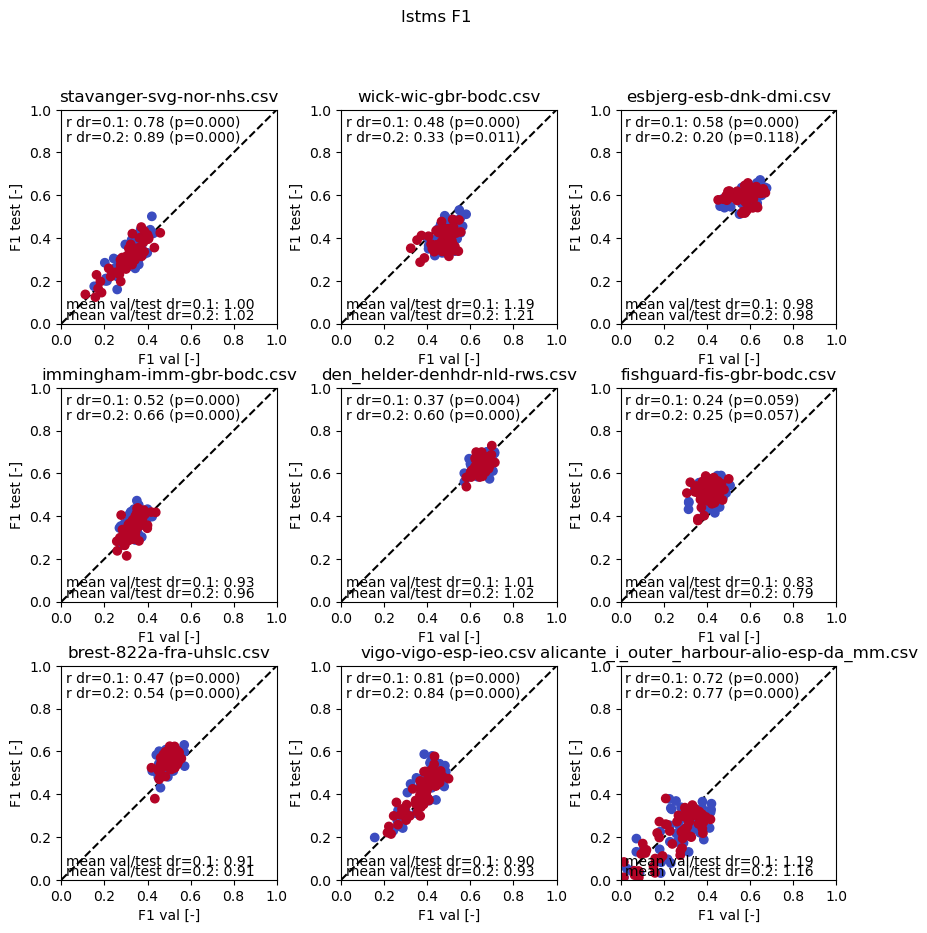

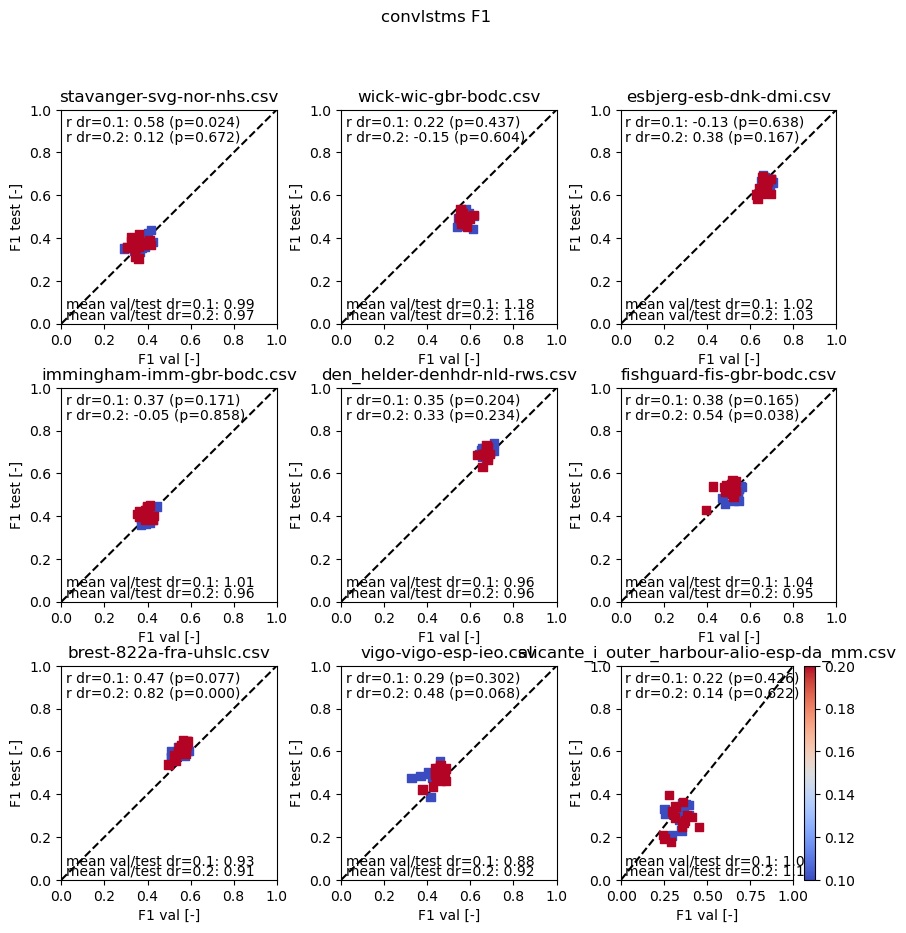

In [10]:
fig=plt.figure(figsize=(10,10)) 
gs = fig.add_gridspec(3,3) #1 row, 3 columns
gs.update(wspace=.3)
gs.update(hspace=.3)
for tg in range(9):
        ax = plt.subplot(gs[np.unravel_index(tg,(3,3))]) 
        
        ax.scatter(lstms.f1.sel(quantile=.99).isel(tg=tg).sel(split='val').stack(i_it=['i','it']),
                   lstms.f1.sel(quantile=.99).isel(tg=tg).sel(split='test').stack(i_it=['i','it']),c=lstms.hyperparameters.sel(p='dropout').isel(tg=2).sel(split='test').stack(i_it=['i','it']),cmap='coolwarm',alpha=.5)
        
        r_01,p_01 = compute_pearsonr(lstms.f1.sel(quantile=.99).where(lstms.hyperparameters.sel(p='dropout')==.1).isel(tg=tg).sel(split='val').values.flatten(),
                                     lstms.f1.sel(quantile=.99).where(lstms.hyperparameters.sel(p='dropout')==.1).isel(tg=tg).sel(split='test').values.flatten())
        
        r_02,p_02 = compute_pearsonr(lstms.f1.sel(quantile=.99).where(lstms.hyperparameters.sel(p='dropout')==.2).isel(tg=tg).sel(split='val').values.flatten(),
                                     lstms.f1.sel(quantile=.99).where(lstms.hyperparameters.sel(p='dropout')==.2).isel(tg=tg).sel(split='test').values.flatten())
        
        ax.text(.02,.07,'mean val/test dr=0.1: '+'{0:.2f}'.format(lstms.f1.sel(quantile=.99).where(lstms.hyperparameters.sel(p='dropout')==.1).isel(tg=tg).sel(split='val').mean()/lstms.f1.sel(quantile=.99).where(lstms.hyperparameters.sel(p='dropout')==.1).isel(tg=tg).sel(split='test').mean()))
        ax.text(.02,.02,'mean val/test dr=0.2: '+'{0:.2f}'.format(lstms.f1.sel(quantile=.99).where(lstms.hyperparameters.sel(p='dropout')==.2).isel(tg=tg).sel(split='val').mean()/lstms.f1.sel(quantile=.99).where(lstms.hyperparameters.sel(p='dropout')==.2).isel(tg=tg).sel(split='test').mean()))

        ax.text(.02,.92,'r dr=0.1: '+'{0:.2f}'.format(r_01)+' (p='+'{0:.3f}'.format(p_01)+')')
        ax.text(.02,.85,'r dr=0.2: '+'{0:.2f}'.format(r_02)+' (p='+'{0:.3f}'.format(p_02)+')')


        ax.set_title(lstms.tg.values[tg])
        ax.plot([0,1],[0,1],linestyle='dashed',color='black',zorder=0)
        ax.set_xlim(0,1)
        ax.set_xlabel('F1 val [-]')
        ax.set_ylim(0,1)
        ax.set_ylabel('F1 test [-]')
        
plt.suptitle('lstms F1')
fig=plt.figure(figsize=(10,10)) 
gs = fig.add_gridspec(3,3) #1 row, 3 columns
gs.update(wspace=.3)
gs.update(hspace=.3)
for tg in range(9):
        ax = plt.subplot(gs[np.unravel_index(tg,(3,3))]) 
        
        ax.scatter(convlstms.f1.sel(quantile=.99).isel(tg=tg).sel(split='val').stack(i_it=['i','it']),
                   convlstms.f1.sel(quantile=.99).isel(tg=tg).sel(split='test').stack(i_it=['i','it']),c=convlstms.hyperparameters.sel(p='dropout').isel(tg=2).sel(split='test').stack(i_it=['i','it']),cmap='coolwarm',marker='s',alpha=.5)
        
        r_01,p_01 = compute_pearsonr(convlstms.f1.sel(quantile=.99).where(convlstms.hyperparameters.sel(p='dropout')==.1).isel(tg=tg).sel(split='val').values.flatten(),
                                     convlstms.f1.sel(quantile=.99).where(convlstms.hyperparameters.sel(p='dropout')==.1).isel(tg=tg).sel(split='test').values.flatten())
        
        r_02,p_02 = compute_pearsonr(convlstms.f1.sel(quantile=.99).where(convlstms.hyperparameters.sel(p='dropout')==.2).isel(tg=tg).sel(split='val').values.flatten(),
                                     convlstms.f1.sel(quantile=.99).where(convlstms.hyperparameters.sel(p='dropout')==.2).isel(tg=tg).sel(split='test').values.flatten())
        
        
        ax.text(.02,.92,'r dr=0.1: '+'{0:.2f}'.format(r_01)+' (p='+'{0:.3f}'.format(p_01)+')')
        ax.text(.02,.85,'r dr=0.2: '+'{0:.2f}'.format(r_02)+' (p='+'{0:.3f}'.format(p_02)+')')

        ax.text(.02,.07,'mean val/test dr=0.1: '+'{0:.2f}'.format(convlstms.f1.sel(quantile=.99).where(convlstms.hyperparameters.sel(p='dropout')==.1).isel(tg=tg).sel(split='val').mean()/convlstms.f1.sel(quantile=.99).where(convlstms.hyperparameters.sel(p='dropout')==.1).isel(tg=tg).sel(split='test').mean()))
        ax.text(.02,.02,'mean val/test dr=0.2: '+'{0:.2f}'.format(convlstms.f1.sel(quantile=.99).where(convlstms.hyperparameters.sel(p='dropout')==.2).isel(tg=tg).sel(split='val').mean()/convlstms.f1.sel(quantile=.99).where(convlstms.hyperparameters.sel(p='dropout')==.2).isel(tg=tg).sel(split='test').mean()))
        
        ax.set_title(convlstms.tg.values[tg])
        ax.plot([0,1],[0,1],linestyle='dashed',color='black',zorder=0)
        ax.set_xlim(0,1)
        ax.set_xlabel('F1 val [-]')
        ax.set_ylim(0,1)
        ax.set_ylabel('F1 test [-]')
fig.colorbar(s, ax=ax)        
plt.suptitle('convlstms F1')   
